In [2]:
import numpy as np
import pandas as pd
import os

In [211]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32
# rawData=rawData.astype(np.float32)

In [210]:
for i in range(len(allcsvs)):
    rawData=pd.read_csv(os.path.join(dataLocation,allcsvs[i]))


# I have to store all of the rawData accurately because I need them afterwards
# or I can make a huge tensor and store all of them in it
# but this raises concerns about the time series consistency

In [24]:
rawData

,Date,Open,High,Low,Close,Volume,Days_Between,Pct_Change
0,2019-10-22 00:00:00+03:00,0.646781,0.652309,0.641253,0.652309,2.818350e+07,1.0,0.000000
1,2019-10-23 00:00:00+03:00,0.657837,0.663365,0.646781,0.663365,2.861088e+07,1.0,0.016949
2,2019-10-24 00:00:00+03:00,0.663365,0.679949,0.652309,0.663365,2.499212e+07,1.0,0.000000
3,2019-10-25 00:00:00+03:00,0.663365,0.663365,0.646781,0.663365,2.711898e+07,1.0,0.000000
4,2019-10-28 00:00:00+03:00,0.668893,0.668893,0.663365,0.663365,2.624481e+07,3.0,0.000000
...,...,...,...,...,...,...,...,...
1247,2024-10-16 00:00:00+03:00,4.050000,4.190000,3.990000,4.070000,7.700599e+07,1.0,0.004938
1248,2024-10-17 00:00:00+03:00,4.060000,4.160000,4.060000,4.160000,7.597829e+07,1.0,0.022113
1249,2024-10-18 00:00:00+03:00,4.170000,4.190000,4.050000,4.190000,7.844818e+07,1.0,0.007212
1250,2024-10-21 00:00:00+03:00,4.150000,4.230000,4.140000,4.150000,7.101958e+07,3.0,-0.009547


In [168]:
lookback_window=7 
#I don't have any idea which number is best
# from past test it looks like model has an understanding of general trend of the stock
# but not the specific chracteristics of the stock
# chatgpt recommends me to increase lookback window

unnecessaryColumns=["Date","Pct_Change"]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


def df_to_X_y(df, scaler ,window_size=5):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  df_as_np = scaler.fit_transform(lightWeightDf.to_numpy())
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size,3]
    y.append(label)
  return np.array(X), np.array(y)

In [169]:
X,y=df_to_X_y(rawData, scaler ,lookback_window)
X.shape, y.shape

((1245, 7, 6), (1245,))

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

num_features=6 #for OHLC, volume and days between
# #TODO for input layer we can use dollar price, australia index,

model1 = Sequential()
model1.add(InputLayer((lookback_window, num_features)))
model1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                4992      
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,265
Trainable params: 5,265
Non-trainable params: 0
_________________________________________________________________


In [128]:
from keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
cp1 = ModelCheckpoint('trainedModels/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [129]:
X_train1, y_train1 = X[:1000], y[:1000]
X_val1, y_val1 = X[1000:], y[1000:]

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

In [ ]:
# from tensorflow.keras.models import load_model
#code for loading the model
# model1 = load_model('trainedModels/')

In [192]:
def deNormalizePrediction(prediction, rawDataframe, scaler):
    length=len(prediction.flatten())
    dummyX=np.zeros((length,6))
    normArray=scaler.fit_transform(rawDataframe.drop(columns=["Date","Pct_Change"]).to_numpy())
    dummyX[:,:3]=normArray[:length,:3]
    dummyX[:,3]=prediction.flatten()
    dummyX[:,3:]=normArray[:length,3:]
    return scaler.inverse_transform(dummyX)[:,3]

In [ ]:
train_predictions = model1.predict(X_train1)

endPred=deNormalizePrediction(train_predictions,rawData,scaler)
train_results = pd.DataFrame(data={'Train Predictions': endPred, 'Actuals':rawData.iloc[:1000,4].to_numpy()})
train_results

32/32 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,0.652309,0.652309
1,0.663365,0.663365
2,0.663365,0.663365
3,0.663365,0.663365
4,0.663365,0.663365
...,...,...
995,6.330000,6.330000
996,6.240000,6.240000
997,6.170000,6.170000
998,6.260000,6.260000


In [207]:
val_predictions = model1.predict(X_val1).flatten()
endPredVal=deNormalizePrediction(val_predictions,rawData,scaler)
# print(len(endPred))
# make sure raw data has the same dimentions
val_results = pd.DataFrame(data={'Val Predictions':endPredVal, 'Actuals':rawData.iloc[1007:,4].to_numpy()})
val_results

8/8 [==============================] - 0s 6ms/step


,Val Predictions,Actuals
0,0.652309,5.51
1,0.663365,5.30
2,0.663365,5.11
3,0.663365,5.15
4,0.663365,5.30
...,...,...
240,1.470460,4.07
241,1.503628,4.16
242,1.498100,4.19
243,1.520212,4.15


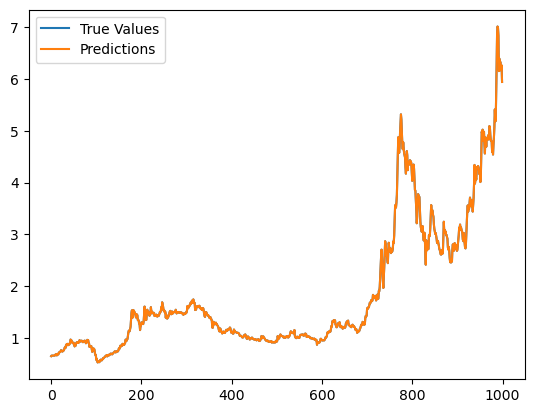

In [205]:
import matplotlib.pyplot as plt
#graph for training data
plt.plot(rawData.iloc[:1000,4].to_numpy(), label='True Values')
plt.plot(endPred, label='Predictions')
plt.legend()
plt.show()

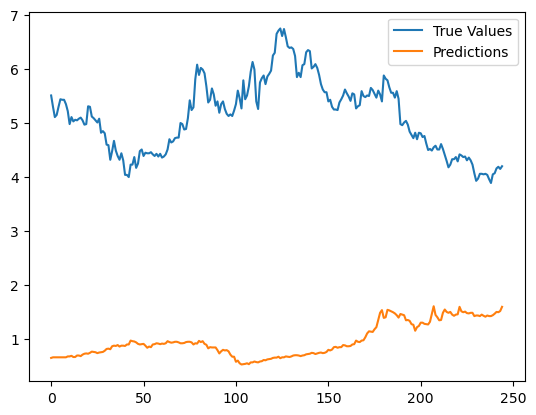

In [208]:
#graph for validation data
plt.plot(rawData.iloc[1007:,4].to_numpy(), label='True Values')
plt.plot(endPredVal, label='Predictions')
plt.legend()
plt.show()
#these both graphs demonstrate val and train set are not split correctly
# the predictions show a great trend for the training data but not for validation set that has a differernt distribution  
# this also shows that the model is way too small to pickup any details on the data (volume and price)